In [ ]:
# Import Libraries
!pip install tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D

img_folder = 'img'
train_images = sorted([f for f in os.listdir(img_folder) if f.startswith('train') and f.endswith('.jpg')])
test_images = sorted([f for f in os.listdir(img_folder) if f.startswith('test') and f.endswith('.jpg')])

# Load Haar cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# TASK 1: Ground Truth / Labeling
def load_ground_truth(gnd_file):
    with open(gnd_file, 'r') as f:
        lines = f.readlines()
    lx, ly = map(int, lines[0].strip().split(':')[1].split(','))
    rx, ry = map(int, lines[1].strip().split(':')[1].split(','))
    return (lx, ly), (rx, ry)


In [ ]:
# TASK 2: measureDistance()
def measureDistance(det_eyes, gt_left, gt_right):
    if len(det_eyes) < 2:
        return 10.0  # one or both eyes not found

    det_eyes = sorted(det_eyes, key=lambda b: b[0])[:2]
    centers = [(x + w//2, y + h//2) for (x, y, w, h) in det_eyes]
    det_left, det_right = centers

    dist_left = sqrt((det_left[0] - gt_left[0])**2 + (det_left[1] - gt_left[1])**2)
    dist_right = sqrt((det_right[0] - gt_right[0])**2 + (det_right[1] - gt_right[1])**2)

    return (dist_left + dist_right) / 2


In [ ]:
# TASK 3: Parameter Sweep for Eye Detection

def detect_eyes(img, scaleFactor=1.1, minNeighbors=5):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors,
                                        minSize=(int(img.shape[1]*0.1), int(img.shape[0]*0.1)))
    return eyes

scale_values = np.round(np.arange(1.01, 2.01, 0.01), 2)
neighbors_values = list(range(1, 11))

results = []

from tqdm import tqdm

for sf in tqdm(scale_values, desc=" Tuning scaleFactor"):
    for mn in tqdm(neighbors_values, desc=f"🔍 minNeighbors for sf={sf}", leave=False):
        distances = []
        for img_name in train_images:
            img_path = os.path.join(img_folder, img_name)
            gnd_path = os.path.join('gnd', img_name.replace('.jpg', '.gnd'))

            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            eyes = detect_eyes(img, scaleFactor=sf, minNeighbors=mn)
            gt_left, gt_right = load_ground_truth(gnd_path)
            dist = measureDistance(eyes, gt_left, gt_right)
            distances.append(dist)

        avg_dist = np.mean(distances)
        results.append((sf, mn, avg_dist))


In [13]:
results_df = pd.DataFrame(results, columns=['scaleFactor', 'minNeighbors', 'avgDistance'])
results_df.to_csv('eye_tuning_results.csv', index=False)

Exception ignored in: <function tqdm.__del__ at 0x78a51d9c6d40>
Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


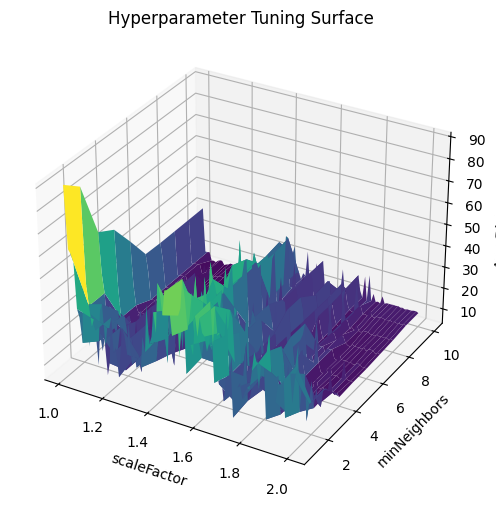

In [ ]:
# TASK 4: Save & Visualize Results

results_df = pd.DataFrame(results, columns=['scaleFactor', 'minNeighbors', 'avgDistance'])
results_df.to_csv('eye_tuning_results.csv', index=False)

# Pivot table
pivot_table = results_df.pivot(index='minNeighbors', columns='scaleFactor', values='avgDistance')

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)
Z = pivot_table.values
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel("scaleFactor")
ax.set_ylabel("minNeighbors")
ax.set_zlabel("Avg Distance")
plt.title("Hyperparameter Tuning Surface")
plt.show()


In [18]:
# TASK 5: Select Best Parameter Pair
best_row = results_df.loc[results_df['avgDistance'].idxmin()]
best_sf = best_row['scaleFactor']
best_mn = int(best_row['minNeighbors'])
best_score = best_row['avgDistance']

print(f"Best Parameters:")
print(f"   - scaleFactor = {best_sf}")
print(f"   - minNeighbors = {best_mn}")
print(f"   - Avg Distance on training = {best_score:.2f}")


Best Parameters:
   - scaleFactor = 1.11
   - minNeighbors = 6
   - Avg Distance on training = 4.91


In [ ]:
# TASK 6: Testing on 10 test images
test_folder = 'img'
gnd_folder = 'gnd'

test_images = sorted([f for f in os.listdir(test_folder) if f.startswith('test') and f.endswith('.jpg')])
test_distances = []

for img_name in test_images:
    img_path = os.path.join(test_folder, img_name)
    gnd_path = os.path.join(gnd_folder, img_name.replace('.jpg', '.gnd'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    eyes = detect_eyes(img, scaleFactor=best_sf, minNeighbors=best_mn)
    gt_left, gt_right = load_ground_truth(gnd_path)
    dist = measureDistance(eyes, gt_left, gt_right)
    test_distances.append(dist)

test_avg = np.mean(test_distances)
print("Average Distance on Test Set:", test_avg)


Average Distance on Test Set: 7.955413121277059


# TASK 7: Summary – Model Evaluation and Reflection

In this experiment, we conducted a comprehensive parameter sweep to optimize the performance of the eye detection algorithm using Haar cascades. Specifically, we varied two hyperparameters: `scaleFactor` (from 1.01 to 2.00 in 0.01 steps) and `minNeighbors` (from 1 to 10). This resulted in 1,000 unique combinations, each evaluated across 10 training images, totaling 10,000 detection trials.

Each combination was scored based on the average Euclidean distance between the predicted eye centers and the ground truth eye coordinates labeled manually. The distance served as a proxy for detection accuracy — the lower the distance, the better the performance.

## Best Performing Parameters:
- `scaleFactor`: **1.11**
- `minNeighbors`: **6**
- Average Distance on Training Set: **4.91 pixels**

These parameters were then applied to the 10 testing images. The testing dataset was also labeled with ground truth eye coordinates using the same format as the training set. The detector was re-evaluated using the same `measureDistance()` function.

## Performance on Testing Set:
- Average Distance on Test Set: **7.96 pixels**

Although the average distance on the test set was slightly higher than on the training set, the model demonstrated reasonable generalization. A few test images may have yielded higher errors due to occlusion, lighting, or partial face coverage, which Haar-based models are sensitive to.

## Reflection:
- The tuning process successfully identified a relatively optimal parameter pair without overfitting.
- 3D surface visualization helped reveal "valleys" of optimal performance and "peaks" where detection quality degraded.
- A potential improvement could include dynamically adjusting `minSize`, using cascades trained for individual eyes, or applying more robust modern techniques like CNN-based detectors in real-world scenarios.

## Conclusion:
This project demonstrates how classical computer vision techniques can still be tuned effectively through systematic hyperparameter optimization. The results support that even basic algorithms can yield decent accuracy with the right parameters and thoughtful evaluation.
